<h1><center>Santander transaction prediction</center></h1>
<h3><center>Predicting customer transactions of Santander Group </center></h3>

Banco Santander, S.A., doing business as Santander Group, is a Spanish multinational commercial bank and financial services company based in Madrid and Santander in Spain. Additionally, Santander maintains a presence in all global financial centres as the 16th-largest banking institution in the world. 
Santander made public an anonymized dataset that contains 200 variables describing whether a customer will or will not perform a transaction. All the columns are numerical.

The aim of this project is to perform predictive analysis on the dataset and eventually predict which customer will perform a transaction and which customer wont.
The dataset can be found at this - <a href="https://www.kaggle.com/c/santander-customer-transaction-prediction/data">Link</a><br>


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import f_classif,mutual_info_classif,SelectPercentile
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import pickle

In [3]:
df = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction-dataset/train.csv')
df.head(10)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
6,train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097
7,train_7,0,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
8,train_8,0,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,...,1.4298,14.7510,1.6395,1.4181,14.8370,-1.9940,-1.0733,8.1975,19.5114,4.8453
9,train_9,0,12.5088,1.9743,8.8960,5.4508,13.6043,-16.2859,6.0637,16.8410,...,0.5543,6.3160,1.0371,3.6885,14.8344,0.4467,14.1287,7.9133,16.2375,14.2514


We will remove the `ID_code` column as it adds no value to the analysis or the model.

In [4]:
df.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [5]:
df.drop('ID_code',axis=1,inplace=True)

Let us first try to see the number of classes and the proportion of each in the dataset.

Text(0.5, 0, 'Target class')

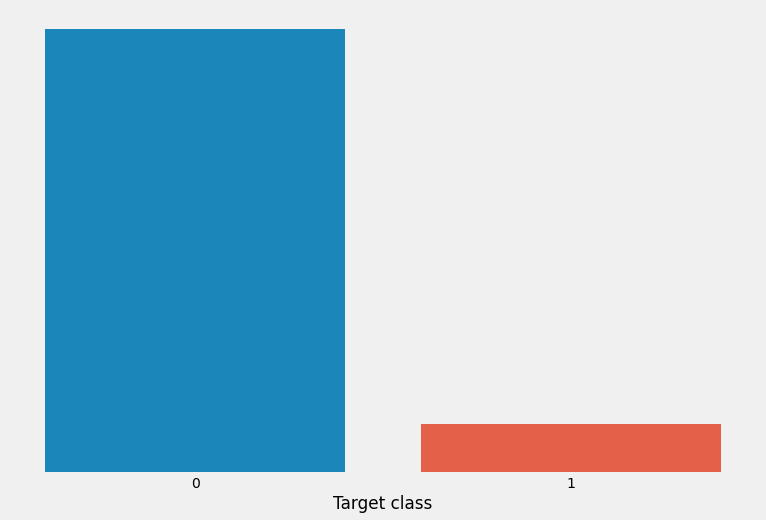

In [6]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
sns.countplot(df.target)
plt.ylabel('')
plt.yticks([])
plt.xlabel('Target class')

The classes are out of proportion. We have overpowering cases of the 0 class (No transaction). <br>
There are two solutions to imbalanced classification problem. We can over sample the class lesser in proportion or under sample the class greater in proportion.<br>
The proportion of the 0 class is very high, thus we will over sample the 1 class using `ADASYN`. Under sampling can be done, but there is a chance we lose out on valuable data for the higher proportion class. `ADASYN` generates synthetic data which is not a repeat of the minority class points. For every minority class point it will find n closest neighbors. Make a line to all those neighbors and points that lie on the line are randomly chosen with some variance to get the new point in the minority class.

In [7]:
y = df.target
X = df.iloc[:,1:]
sampler = ADASYN(random_state=0)
overSamp_X,overSamp_y = sampler.fit_resample(X,y)
overSamp_y.value_counts(dropna=False)

1    187938
0    179902
Name: target, dtype: int64

The code is given below, is for under sampling using `RandomUnderSampler`. The code is attached only for reference, but we are not using this method.

In [8]:
y = df.target
X = df.iloc[:,1:]
sampler = RandomUnderSampler(random_state=0)
underSamp_X,underSamp_y = sampler.fit_sample(X,y)
underSamp_y.value_counts(dropna=False)

Once we have the data resampled, we will `concat` the data together to form a dataframe again for further analysis, this way it will be easier incase we have to remove any rows or make changes in the data<br>

Now let us explore the data, try to find relations if possible and perform feature extraction. 

In [9]:
df = pd.concat([overSamp_X,overSamp_y],axis=1)
df = df.sample(frac=1,random_state=1) #To randomize the data
df.head(10)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
254549,12.801032,-0.234137,7.204692,6.488525,11.877978,-10.991217,5.109014,14.690664,-1.997388,8.097423,...,9.527156,2.000823,7.005444,18.052214,0.437979,11.948677,9.252721,11.386613,7.455510,1
339646,11.758228,-4.113063,13.852329,10.214027,11.924109,6.935680,6.641500,19.971275,4.919980,7.165361,...,9.659922,2.442496,-0.161721,19.290915,0.161389,-2.082418,9.443250,15.682495,8.300173,1
288990,16.130706,-3.969707,10.118114,6.724830,11.085619,-8.204975,4.955094,11.683073,3.069200,7.396528,...,3.416596,2.465079,3.906831,21.049500,0.848300,5.334066,9.337713,14.847017,-12.612345,1
251370,7.643475,0.806717,12.113520,8.647463,13.101162,-14.492049,4.634995,16.021046,-2.708482,6.355035,...,6.108591,3.600922,5.629327,16.715065,-1.495991,9.069211,8.864333,10.627334,-8.150509,1
262933,8.988784,0.348474,9.613160,5.020276,9.147571,0.195828,5.549134,20.847315,1.022663,8.533282,...,6.400665,0.936761,7.735676,18.273099,0.595127,2.635183,8.829247,16.942815,6.520807,1
35127,10.807000,1.198400,13.847800,4.758500,11.867500,-8.303400,6.104400,15.826800,4.673800,6.907600,...,13.882900,1.105500,6.318700,17.054400,-0.462600,4.695400,8.981300,11.655600,-1.198500,0
137367,7.628800,0.712200,7.624400,4.726600,11.515000,0.905500,6.491300,19.799100,2.295700,7.998000,...,4.771800,3.626700,8.424500,21.540600,-3.006400,0.424500,10.207500,15.816900,4.896900,0
202392,12.053214,-3.808164,14.912667,5.015039,11.344741,-16.684191,6.417626,11.207981,2.068909,6.361619,...,9.063199,3.234551,4.383339,21.191785,0.031064,-0.095146,8.723784,19.949944,3.853575,1
88981,9.231700,-0.024500,11.503100,3.790500,11.723000,-9.313600,5.765600,16.759300,1.328700,8.962100,...,9.276800,1.506000,4.709600,21.546100,1.067500,-5.171100,7.975100,11.881600,-22.600000,0
286456,11.706073,-0.845476,13.214649,7.430901,11.359308,-1.423411,6.008622,15.439566,-1.751960,6.152053,...,1.744418,1.451225,8.783622,17.160841,0.853086,9.563296,7.318500,11.869730,5.616239,1


All the columns are numeric and continuous in nature as described on the dataset's link. We can apply ANOVA test for finding the most important features using the `f_classif` function.<br>

The `f_classif` function uses the ANOVA test only to check for Linear dependency and accordingly gives the result.

In [10]:
F_stat,p_value = f_classif(df.drop('target',axis=1),df.target)
for col,stat,p in zip(df.drop('target',axis=1),F_stat,p_value):
    print(col,stat," : ",p)

var_0 2880.596646734631  :  0.0
var_1 2767.0773498419276  :  0.0
var_2 3499.8344187527073  :  0.0
var_3 178.46681019146146  :  1.0707517604771611e-40
var_4 139.34463719900498  :  3.752671213780399e-32
var_5 950.8719785378613  :  1.585533998465283e-208
var_6 5422.082887703735  :  0.0
var_7 9.398230075857096  :  0.0021721074958717603
var_8 367.46714903370224  :  7.306785278062584e-82
var_9 1937.4087918065331  :  0.0
var_10 0.4817133311994325  :  0.48764770956572745
var_11 590.5321083427685  :  2.434103152564295e-130
var_12 5625.105055808305  :  0.0
var_13 3122.665512014799  :  0.0
var_14 52.45766452553203  :  4.404779383427984e-13
var_15 274.2333334721079  :  1.4277328222095105e-61
var_16 17.614090000414464  :  2.7063962320863778e-05
var_17 4.133763691408472  :  0.04203647854709667
var_18 1957.2266592880344  :  0.0
var_19 71.98924521853696  :  2.1715790108909987e-17
var_20 399.4011316578865  :  8.290633454965593e-89
var_21 3744.7963118813354  :  0.0
var_22 3843.5941515633813  :  0.0
var_

There may be a non-linear dependency between the target and features. For this reason we will run the `mutual_info_classif` to even account for non-linear dependencies and gives us a statistic to estimate which features are most important for classification.

In [11]:
test_stat = mutual_info_classif(df.drop('target',axis=1),df.target)
for col,stat in zip(df.drop('target',axis=1),test_stat):
    print(col,stat)

var_0 0.03995443102748908
var_1 0.029118609419350294
var_2 0.052256389990300356
var_3 0.0807012533498832
var_4 0.1246630354528524
var_5 0.012907652728065155
var_6 0.26623380233185845
var_7 0.025114642438301527
var_8 0.03268485779045793
var_9 0.1911544596753727
var_10 0.014006110924205784
var_11 0.013325222846307883
var_12 0.4212736955499299
var_13 0.022912974855929358
var_14 0.06312854015998681
var_15 0.3661915382151697
var_16 0.05107093589124556
var_17 0.01065912291667881
var_18 0.01621359758226415
var_19 0.009646349576900581
var_20 0.01765667048689501
var_21 0.017012312457121537
var_22 0.04507845718913139
var_23 0.34237473594806356
var_24 0.030910206478742097
var_25 0.3915353752942614
var_26 0.018352232374188482
var_27 0.140209216920421
var_28 0.2866816278118578
var_29 0.048653450848811675
var_30 0.008808841525384858
var_31 0.07873290157618507
var_32 0.050116018526985995
var_33 0.02524697645945695
var_34 0.33868357197220456
var_35 0.017608917164491533
var_36 0.03672901115182481
var_3

The higher the value, the more important that feature is. The `SelectPercentile` function is used to select upto the 35 percentile features with best score on `mutual_info_classif`. This way we remove those features from out model that are irrelevant to the model and may introduce bias to the model if added.

In [12]:
X = df.drop('target',axis=1)
y = df.target
selector = SelectPercentile(percentile=35,score_func=mutual_info_classif)
X = pd.DataFrame(selector.fit_transform(X,y))
X.shape

(367840, 70)

From the initial haul of 200 columns, we preserved 70 columns. We will build the model using these columns, as they have been tested to be the most important for the target variable.<br>

We need to normalize the data so that all columns are on the same scale and no bias is introduced into the model.
We will use the `MinMaxScaler` for this purpose.

In [13]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1)

The model we will use is the `GradientBoostingClassifier`. It uses an ensemble of trees as predictors to reduce biases introduced in the data/model.

In [14]:
gbm = GradientBoostingClassifier(n_estimators=500,learning_rate=0.05,max_depth=9,verbose=1)
gbm.fit(X_train,y_train)
print(gbm.score(X_train,y_train))
print(gbm.score(X_test,y_test))c

      Iter       Train Loss   Remaining Time 
         1           1.3702          222.40m
         2           1.3556          224.12m
         3           1.3414          225.36m
         4           1.3276          223.92m
         5           1.3145          222.88m
         6           1.3016          222.60m
         7           1.2894          222.86m
         8           1.2775          222.27m
         9           1.2657          221.78m
        10           1.2544          221.09m
        20           1.1557          216.49m
        30           1.0758          214.82m
        40           1.0082          212.35m
        50           0.9509          207.42m
        60           0.9003          203.60m
        70           0.8552          198.45m
        80           0.8152          193.63m
        90           0.7804          189.36m
       100           0.7485          184.96m
       200           0.5394          138.31m
       300           0.4262           92.57m
       40

The `GradientBoostingClassifier` is initialized with 500 trees as estimators, a learning rate of 0.05 and max depth of each tree capped at 9. Due to the size of the data, hyperparameter tuning is done via hit and trial rather than a grid search or random search.<br> <br>
The model performed reasonably with a train set accuracy of about 98% and test set accuracy of about 90%. The accuracy is just one part of the picture when we are talking about classification, for a more detailed report we will use the `classification_report` function. This will give us results for precision and recall of the model.

In [15]:
y_pred = gbm.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     44228
           1       0.92      0.90      0.91     47732

    accuracy                           0.90     91960
   macro avg       0.90      0.90      0.90     91960
weighted avg       0.90      0.90      0.90     91960



The precision and recall for the model seemed to be at par with the test accuracy, at around 90%. This indicates a very good fit to the data. <br>
We have a basic idea on how well our model can work on this data. To visualize the model's efficiency, a ROC curve is plotted below.

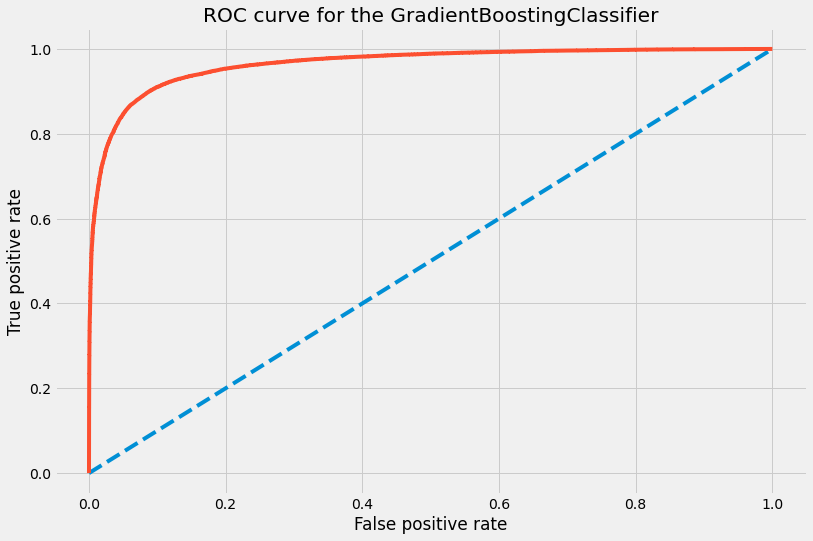

0.9645223809429099


In [47]:
noskill_pred = [0 for i in range(len(X_test))]
mod_pred = gbm.predict_proba(X_test)
mod_pred_posv = mod_pred[:,1]

ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_pred)
mod_fpr, mod_tpr, _ = roc_curve(y_test, mod_pred_posv)

plt.style.use('fivethirtyeight')
plt.figure(figsize= (12,8))
plt.plot(ns_fpr,ns_tpr, linestyle= '--', label= 'Dummy classifier')
plt.plot(mod_fpr, mod_tpr, linestyle= '-', label= 'Model classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for the GradientBoostingClassifier')
plt.show()

print(auc(mod_fpr, mod_tpr))

The ROC curve shows that the model built has a good tradeoff between False positive rate and True positive rate. As compared to a dummy classifier, its Area under the Curve is much larger as 0.965.

The next model to be tried is the `RandomForestClassifier`. It is a robust model and immune to overfitting due to multiple random trees created whose output is then merged. The `RandomForestClassifier` may not result is a better model than the `GradientBoostingClassifier` but it is just used here as a comparision of the two.

In [44]:
model = RandomForestClassifier(n_estimators=500,max_depth= 17,verbose=2)
model.fit(X_train,y_train)
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 500


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500


building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 32.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   39.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


0.9464187327823691
0.8762396694214876


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   13.3s finished


The `RandomForestClassifier` is built with 500 estimators and max depth as 17. Due to the size of the data, hyperparameter tuning is done via hit and trial rather than a grid search or random search.<br>
The model as seen performs considerably well with a train set accuracy of 94% and test set accuracy of about 88%. The `classification_report` gives a detailed view of the fit of the model on data.

In [45]:
y_pred = model.predict(X_test)
print(classification_report(y_pred,y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


              precision    recall  f1-score   support

           0       0.82      0.92      0.87     40017
           1       0.93      0.84      0.88     51943

    accuracy                           0.88     91960
   macro avg       0.88      0.88      0.88     91960
weighted avg       0.88      0.88      0.88     91960



[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   13.4s finished


The model performs very well, giving a precision and recall at par with the accuracy of the model, at 88%. This shows a good fit. The ROC curve visualizes the goodness of a model.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.3s finished


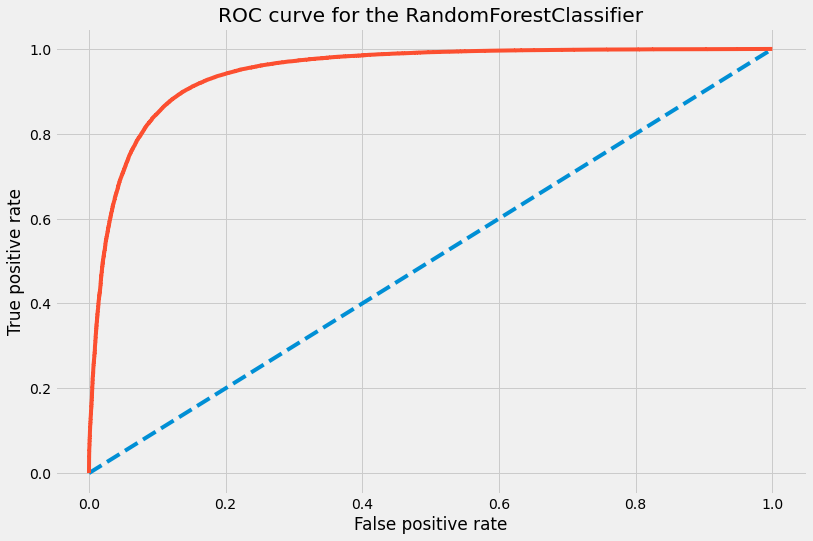

0.9464636114790845


In [48]:
noskill_pred = [0 for i in range(len(X_test))]
mod_pred = model.predict_proba(X_test)
mod_pred_posv = mod_pred[:,1]

ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_pred)
mod_fpr, mod_tpr, _ = roc_curve(y_test, mod_pred_posv)

plt.style.use('fivethirtyeight')
plt.figure(figsize= (12,8))
plt.plot(ns_fpr,ns_tpr, linestyle= '--', label= 'Dummy classifier')
plt.plot(mod_fpr, mod_tpr, linestyle= '-', label= 'Model classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for the RandomForestClassifier')
plt.show()

print(auc(mod_fpr, mod_tpr))

As compared to the `GradientBoostingClassifier`, the `RandomForestClassifier` shows a slightly lesser Area under the curve at about 0.946, but mimics the curve. Nonetheless the plot shows a good tradeoff between False positive rate and True positive rate.<br>



The conclusions drawn are:-
* The dataset is highly imbalanced and a over sampling technique is used.
* Due to the high dimensionality in the data, it was imperative to perform feature selection. The feature selection is performed using mutual information.
* The `GradientBoostingClassifier` out performs the `RandomForestClassifier` slightly.
* Both the models show a good precision, recall and F1 score.
* The final model chosen is the `GradientBoostingClassifier`.
* Due to the size of the data, given the resources it was difficult to perform sophisticated hyper parameter tuning methods and hence was done via hit and trial.